# Longitudinal QuasiCopula GWAS

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using QuasiCopula
using Random
using GLM
using LinearAlgebra
using Statistics
using StatsBase

ENV["COLUMNS"] = 240
BLAS.set_num_threads(1)
Threads.nthreads()

Precompiling QuasiCopula
  ✓ QuasiCopula
  1 dependency successfully precompiled in 5 seconds. 151 already precompiled.


8

## Simulate data

All SNPs have the same MAF

In [12]:
k = 0 # number of causal SNPs

qc_model, G, βtrue, θtrue, γtrue, τtrue = simulate_longitudinal_traits(
    n = 10_000, # sample size
    d_min = 5, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 15, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 10000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2024,
    y_distribution = Bernoulli,
    τtrue = 0.5,
    T = Float64,
    maf = 0.3,
    causal_snp_β = 0.2,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Bernoulli
  * link function: LogitLink
  * number of clusters: 10000
  * cluster size min, max: 5, 5
  * number of variance components: 2
  * number of fixed effects: 15



In [7]:
# simulated Γ
Γ = qc_model.data[1].V[1] * θtrue[1] + qc_model.data[1].V[2] * θtrue[2]

5×5 Matrix{Float64}:
 0.11  0.1   0.1   0.1   0.1
 0.1   0.11  0.1   0.1   0.1
 0.1   0.1   0.11  0.1   0.1
 0.1   0.1   0.1   0.11  0.1
 0.1   0.1   0.1   0.1   0.11

In [4]:
# check response
Y = hcat([qc_model.data[i].y for i in 1:length(qc_model.data)]...)'
Statistics.cor(Y)

5×5 Matrix{Float64}:
 1.0        0.0395978  0.0412608  0.0469872  0.04467
 0.0395978  1.0        0.0439956  0.0406976  0.0467024
 0.0412608  0.0439956  1.0        0.050163   0.04529
 0.0469872  0.0406976  0.050163   1.0        0.0453676
 0.04467    0.0467024  0.04529    0.0453676  1.0

In [52]:
Y

10000×5 adjoint(::Matrix{Float64}) with eltype Float64:
  3.93727   -2.34964     1.15502    0.845882   -2.25056
  1.239     -1.41874     1.10158   -1.54951     1.55236
 -2.26558   -3.68031     2.20243    1.10832     1.05051
  1.94291    0.630906   -0.123103   2.12125     1.27238
 -0.256513   2.95857    -4.80642   -0.289042   -2.71634
  2.48586    6.17372    -2.65617   -0.834607    1.30696
  1.00082    1.04486    -3.16515    0.290777    3.01215
  4.06211   -3.00305    -0.199011   4.43849     2.42237
  1.33301   -5.50109     1.94873    6.30419    -0.478857
  2.67229    2.43302     0.611184  -0.505642   -0.300268
  2.63139    5.73512     4.93054   -0.52798    -1.54477
  1.54158   -0.164176   -1.30372    0.8517      0.284256
  4.39541    1.82224     1.52061    1.25152    -1.28981
  ⋮                                            
  2.36584   -2.10804     0.968788   1.32022     3.81198
  2.13142   -2.20301     2.96436   -2.32653     3.96701
  4.53744   -3.48772     1.71259    0.0926616  -2.641

Mathematically, $cov(Y_k, Y_l) = \sigma_k\sigma_l\gamma_{kl}$. Lets check this.

In [15]:
k = 1
l = 2

# bernoulli
pk = count(isone, Y[:, k]) / size(Y, 1)
pl = count(isone, Y[:, l]) / size(Y, 1)
σk = sqrt(pk * (1 - pk))
σl = sqrt(pl * (1 - pl))

# gaussian
# σk = std(Y[:, k])
# σl = std(Y[:, l])

σk * σl * Γ[k, l]

24.229478198003438

## Fit null model

In [13]:
@time optm = QuasiCopula.fit!(qc_model);

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       17
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.4636370e+04 0.00e+00 1.01e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [14]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

@show τtrue
@show qc_model.τ
@show qc_model.∇τ;

βtrue = [1.0, -0.5, 0.5, 0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, -0.5, -0.5, 0.5, -0.5, -0.5]
qc_model.β = [0.9827134561727707, -0.47940244143915933, 0.5174496069038467, 0.4950032115433862, 0.5087750230847607, -0.5040581892712337, 0.5020256574548326, -0.5155684410674687, 0.5092740027555162, -0.5183844326248955, -0.4920488793196099, -0.4919582025840505, 0.5080168758163492, -0.49413206512267394, -0.5078169798839528]
qc_model.∇β = [-0.00025731390816918775, -0.0016083348179851686, 0.0005878630996927203, -0.001404604088353134, 0.0003259788246068318, -4.211587823155227e-5, -3.2856611190679175e-6, -4.42029071288097e-5, -0.000780626519024219, -8.017265391907502e-5, 0.0007286382698049598, 0.0007995234004883889, 0.0008373530469657497, -0.0008245015735451056, -0.001174809759368567]
θtrue = [0.1, 0.1]
qc_model.θ = [0.09153833977611477, 0.16759906062856658]
qc_model.∇θ = [-0.0004742208136141457, -0.00021518405981474364]
τtrue = 0.5
qc_model.τ = [1.0]
qc_model.∇τ = [0.0]


## Score test GWAS

In [15]:
pvals, zscores = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


Wtime = 20.643403132624567
Qtime = 5.374567490874803
Rtime = 1.9579474104997692
grad_res_time = 2.780907761499762
othertime = 1.3478217988750139
scoretest_time = 0.0059592375


([0.6849159712971491, 0.14433590855217768, 0.3404617817398242, 0.952281129737565, 0.4573267099124567, 0.538311108765152, 0.07848007483672663, 0.5382381840952588, 0.8302977485840336, 0.5706150117813622  …  0.001436023939160413, 0.3995297397752879, 0.9066151049236842, 0.17050734352857833, 0.07825926487927923, 0.47692085205019186, 0.5690737979306789, 0.38537673252951893, 0.08992343299355803, 0.7406401418821085], [-0.405764055973466, -1.459833247723824, 0.9532532309116356, -0.05984243266169565, 0.7432559919146194, -0.6153689247596537, 1.759573930928972, -0.6154793779467577, -0.21431971022837443, 0.5671459714590709  …  3.1873107609899636, -0.8424613952616303, -0.11730911153717256, -1.3705754397183394, 1.7608767559054022, 0.711263682929197, -0.5694160932548277, -0.8680321503292925, 1.6958017393345033, -0.3310057505321731])

In [10]:
pvals, zscores = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)
pvals_true = QuasiCopula.GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false)
[pvals pvals_true]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Wtime = 2.102037339499975
Qtime = 0.5209478142499835
Rtime = 0.1823866542499868
grad_res_time = 0.2677167359999902
othertime = 0.1191886968750048
scoretest_time = 0.0005877921249999999


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


grad time = 7.096849045000008
hess time = 60.77018596800009


1000×2 Matrix{Float64}:
 0.142311   0.142311
 0.278248   0.278248
 0.170138   0.170138
 0.289841   0.289841
 0.511991   0.511991
 0.516806   0.516806
 0.714419   0.714419
 0.518506   0.518506
 0.58182    0.58182
 0.979344   0.979344
 0.512285   0.512285
 0.331202   0.331202
 0.313976   0.313976
 ⋮          
 0.861879   0.861879
 0.318918   0.318918
 0.665325   0.665325
 0.827096   0.827096
 0.316801   0.316801
 0.655838   0.655838
 0.0874767  0.0874767
 0.201261   0.201261
 0.602532   0.602532
 0.967972   0.967972
 0.50984    0.50984
 0.28663    0.28663

In [6]:
# 3/29 MOI, parallel Gaussian, 8 thread (N=100,000, P=15, d=5 obs per sample, 1000 SNPs)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


Wtime = 19.652710544124
Qtime = 5.39726007225101
Rtime = 2.1900243871260856
grad_res_time = 3.1322197800013845
othertime = 1.1965336403748155
scoretest_time = 0.003489691875
 40.286343 seconds (421.11 M allocations: 19.368 GiB, 4.62% gc time, 18.58% compilation time)


1000-element Vector{Float64}:
 0.6029988537647152
 0.4065826843119455
 0.4667487975110792
 0.26655824445898985
 0.7539742005423752
 0.25183821678372625
 0.22390130880001952
 0.5935630700739397
 0.02771408554647976
 0.5105219839683984
 0.33793575665489556
 0.5694187270621743
 0.19015891655380102
 ⋮
 0.8763727825290223
 0.27847490487727194
 0.829687635784242
 0.10240912806134564
 0.4229479287454143
 0.2587536719696957
 0.3291437438327995
 0.07586583807367776
 0.07563089589102077
 0.19769783519841144
 0.13936790523931403
 0.40471160098073095

In [7]:
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false)

LoadError: UndefVarError: `A_mul_b!` not defined

In [15]:
# 3/29 (MOI) parallel Bernoulli, 8 thread (N=100,000, P=15, d=5 obs per sample, 1000 SNPs)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


Wtime = 22.004541937249066
Qtime = 6.178510744254076
Rtime = 2.4601658247499447
grad_res_time = 3.041564802501413
othertime = 1.359136816124779
scoretest_time = 0.0008751691249999998
 41.574657 seconds (413.35 M allocations: 18.876 GiB, 3.76% gc time)


1000-element Vector{Float64}:
 0.6029988537647152
 0.4065826843119455
 0.4667487975110792
 0.26655824445898985
 0.7539742005423752
 0.25183821678372625
 0.22390130880001952
 0.5935630700739397
 0.02771408554647976
 0.5105219839683984
 0.33793575665489556
 0.5694187270621743
 0.19015891655380102
 ⋮
 0.8763727825290223
 0.27847490487727194
 0.829687635784242
 0.10240912806134564
 0.4229479287454143
 0.2587536719696957
 0.3291437438327995
 0.07586583807367776
 0.07563089589102077
 0.19769783519841144
 0.13936790523931403
 0.40471160098073095

In [24]:
# 3/15 parallel Bernoulli, 8 thread (N=100,000, P=15, d=5 obs per sample, 1000 SNPs)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

 52.776310 seconds (418.76 M allocations: 19.220 GiB, 3.78% gc time, 20.22% compilation time)


1000-element Vector{Float64}:
 0.6029988537647123
 0.40658268431193156
 0.4667487975110738
 0.26655824445898874
 0.7539742005423871
 0.25183821678373725
 0.223901308800027
 0.5935630700739444
 0.02771408554648064
 0.5105219839683997
 0.33793575665490105
 0.5694187270621732
 0.19015891655379438
 ⋮
 0.8763727825290336
 0.27847490487727605
 0.8296876357842508
 0.10240912806134486
 0.4229479287454222
 0.2587536719696966
 0.3291437438328065
 0.07586583807367729
 0.07563089589101633
 0.197697835198405
 0.13936790523931386
 0.4047116009807252

In [5]:
# 3/15 parallel Bernoulli, 8 thread (N=100,000, P=15, d=5 obs per sample, 1000 SNPs)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


Wtime = 25.71952526550067
Qtime = 8.984551497002137
Rtime = 3.3008138740030075
grad_res_time = 3.785382601125927
othertime = 1.8043504316253838
scoretest_time = 0.00448950025
 56.041838 seconds (420.80 M allocations: 19.350 GiB, 1.21% gc time, 26.68% compilation time)


1000-element Vector{Float64}:
 0.6029988537647123
 0.40658268431193156
 0.4667487975110738
 0.26655824445898874
 0.7539742005423871
 0.25183821678373725
 0.223901308800027
 0.5935630700739444
 0.02771408554648064
 0.5105219839683997
 0.33793575665490105
 0.5694187270621732
 0.19015891655379438
 ⋮
 0.8763727825290336
 0.27847490487727605
 0.8296876357842508
 0.10240912806134486
 0.4229479287454222
 0.2587536719696966
 0.3291437438328065
 0.07586583807367729
 0.07563089589101633
 0.197697835198405
 0.13936790523931386
 0.4047116009807252

In [5]:
# 3/15 parallel Gaussian (N=100,000, P=15, d=5 obs per sample, 100 SNPs)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)
@time pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false)
[pvals pvals2]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


sum(Wtime) = 22.520507060983817
sum(Qtime) = 6.915011703015185
sum(Rtime) = 3.0075901789993273
sum(grad_res_time) = 3.7176432869933786
sum(othertime) = 11.203956196007587
sum(scoretest_time) = 0.019538668
 11.757446 seconds (90.87 M allocations: 14.886 GiB, 5.89% gc time, 126.21% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


grad time = 10.363051826000001
hess time = 103.60265091400005
128.294540 seconds (11.49 M allocations: 733.843 MiB, 0.08% gc time, 4.09% compilation time)


100×2 Matrix{Float64}:
 0.0984103  0.0984103
 0.278425   0.278425
 0.277576   0.277576
 0.562382   0.562382
 0.399695   0.399695
 0.189491   0.189491
 0.292521   0.292521
 0.633038   0.633038
 0.115893   0.115893
 0.468527   0.468527
 0.876708   0.876708
 0.81228    0.81228
 0.254616   0.254616
 ⋮          
 0.292208   0.292208
 0.677507   0.677507
 0.491727   0.491727
 0.384618   0.384618
 0.675634   0.675634
 0.054762   0.054762
 0.550491   0.550491
 0.0727033  0.0727033
 0.105073   0.105073
 0.796414   0.796414
 0.082747   0.082747
 0.494939   0.494939

In [5]:
# 3/15 Gaussian (N=100,000, P=15, d=5 obs per sample)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)
@time pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff_fast(qc_model, G, check_grad=false)
[pvals pvals2]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


Wtime = 13.768972457786282
Qtime = 4.800775802682142
Rtime = 1.8043157240891272
grad_res_time = 3.3286357528364854
othertime = 3.12138809897846
scoretest_time = 0.005822122999999997
 36.738384 seconds (20.06 M allocations: 13.341 GiB, 5.07% gc time, 9.48% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


grad time = 10.986382379
hess time = 101.71939357700003
127.214839 seconds (11.64 M allocations: 739.785 MiB, 0.08% gc time, 4.40% compilation time)


100×2 Matrix{Float64}:
 0.0984103  0.0984103
 0.278425   0.278425
 0.277576   0.277576
 0.562382   0.562382
 0.399695   0.399695
 0.189491   0.189491
 0.292521   0.292521
 0.633038   0.633038
 0.115893   0.115893
 0.468527   0.468527
 0.876708   0.876708
 0.81228    0.81228
 0.254616   0.254616
 ⋮          
 0.292208   0.292208
 0.677507   0.677507
 0.491727   0.491727
 0.384618   0.384618
 0.675634   0.675634
 0.054762   0.054762
 0.550491   0.550491
 0.0727033  0.0727033
 0.105073   0.105073
 0.796414   0.796414
 0.082747   0.082747
 0.494939   0.494939

In [19]:
# 3/13/2024 Bernoulli optimized away allocations + inline (N=100,000, P=15, d=5 obs per sample, Bernoulli)
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


Wtime = 13.823160521727385
Qtime = 4.8231576666749
Rtime = 1.7943300880687147
grad_res_time = 2.74373440804863
othertime = 3.342375513974367
scoretest_time = 0.001090289
 32.172534 seconds (12.59 M allocations: 12.820 GiB, 2.32% gc time, 0.52% compilation time)


100-element Vector{Float64}:
 0.6187728572609951
 0.8496667233330221
 0.40974196937222623
 0.5671957640255685
 0.46214111768624644
 0.7807307761430159
 0.002915186427295331
 0.9081736689430064
 0.08427231587790641
 0.737858003745425
 0.23694038429038083
 0.8833033494335396
 0.6129319697421085
 ⋮
 0.008245693236827225
 0.6310435761356239
 0.02900575228042566
 0.3050493485911325
 0.04485059136883662
 0.05784310364023999
 0.2692557868556426
 0.7408150252581713
 0.8663919149998177
 0.32387023749450206
 0.11494644685131016
 0.37332203886960197

In [36]:
# 3/11/2024 Bernoulli pre-optimizing (N=100,000, P=15, d=5 obs per sample, Bernoulli)
@time pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:03


Wtime = 151.45075288451383
Qtime = 14.949879267721332
Rtime = 2.5083309525981132
193.969275 seconds (1.49 G allocations: 210.847 GiB, 18.29% gc time)


100-element Vector{Float64}:
 0.6187728572609951
 0.8496667233330198
 0.4097419693722258
 0.5671957640255666
 0.4621411176862497
 0.780730776143015
 0.00291518642729541
 0.9081736689430064
 0.08427231587790672
 0.7378580037454281
 0.23694038429038128
 0.8833033494335386
 0.6129319697421055
 ⋮
 0.008245693236827153
 0.6310435761356203
 0.029005752280425737
 0.3050493485911328
 0.04485059136883624
 0.057843103640240055
 0.2692557868556421
 0.7408150252581676
 0.8663919149998188
 0.3238702374944988
 0.11494644685131038
 0.3733220388696007

## Distribution of Z-scores

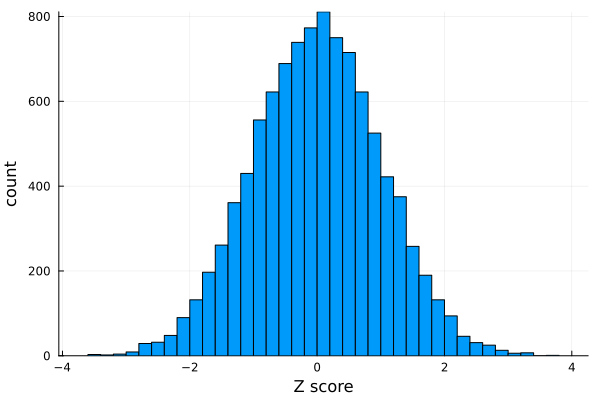

In [21]:
using Plots
gr(fmt=:png)
histogram(zscores, xlabel="Z score", ylabel=count, legend=false)

## QQ plots

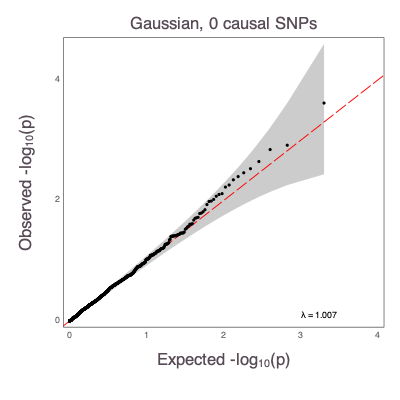

In [12]:
# gaussian
qq(pvals, dpi=80, titles="Gaussian, $k causal SNPs")
display("image/png", read("qqplot.png"))

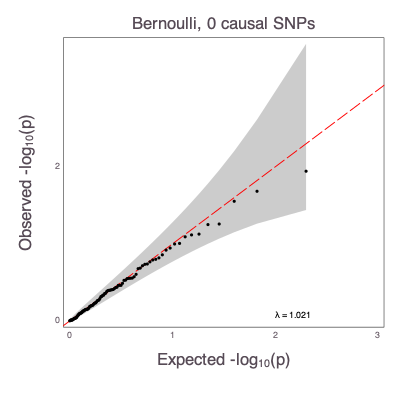

In [27]:
# Bernoulli
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

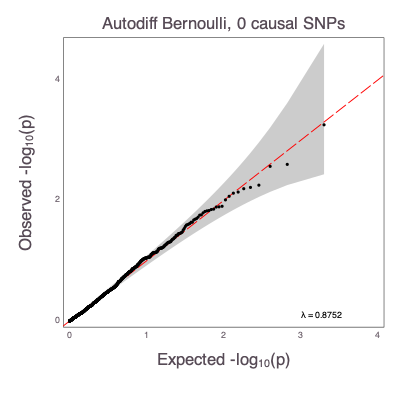

In [24]:
qq(pvals, dpi=80, titles="Autodiff Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))